# Source position continuous optimisation based on FWI results (test case B and D)

In [1]:
import os

###############################################################################
# Decide on CPU or GPU here
use_gpu = False  # Set to False if you want CPU only
###############################################################################

if use_gpu:
    # Prevent JAX from preallocating most of the GPU memory
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
    # Force JAX to use GPU
    import jax
    jax.config.update("jax_platform_name", "gpu")
else:
    # Force JAX to use CPU
    import jax
    jax.config.update("jax_platform_name", "cpu")

In [2]:
import numpy as np
from jax import jit, vjp, vmap, value_and_grad, random
import jax
from jax import numpy as jnp
from jaxdf.operators import compose
from matplotlib import pyplot as plt
import optax
import equinox as eqx
from jax.example_libraries import optimizers
import time


from jwave.geometry import Domain, Medium
from jwave.signal_processing import smooth

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field, generate_2D_gridded_src_rec_positions, ricker_wavelet, acoustic2D, acoustic2D_pml,acoustic2D_pml_minmem, acoustic2D_pml_4th_minmem, generate_src_rec_positions

from hybridoed.oed import *


(500, 1, 70, 70)


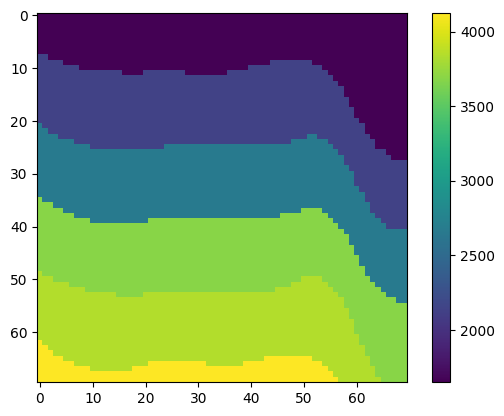

<class 'jaxlib.xla_extension.ArrayImpl'>


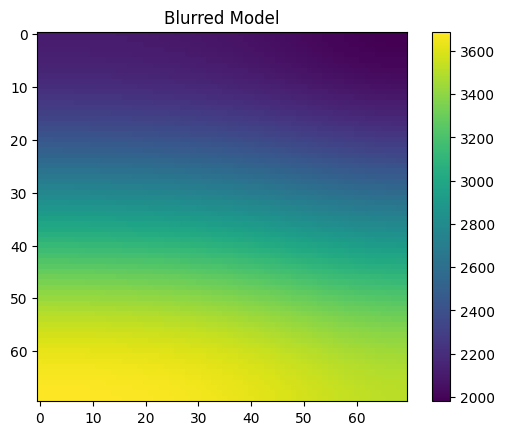

(70, 70)


In [3]:
# Load model

model = jnp.load('model1.npy')

print(model.shape)

model_index = 84

true_model = model[model_index,0,:,:]
# true_model = model
plt.imshow(true_model)
plt.colorbar()
plt.show()
print(type(true_model))

from scipy.ndimage import gaussian_filter

# Apply a Gaussian blur
# Adjust sigma as needed; larger sigma = more blur
blurred_model = gaussian_filter(true_model, sigma=20)

# Visualize the blurred model
plt.figure()
plt.imshow(blurred_model, cmap='viridis')
plt.colorbar()
plt.title('Blurred Model')
plt.show()
print(blurred_model.shape)

# homogenous model of the velocity avegare

homogenous_model = jnp.ones(true_model.shape) * jnp.mean(true_model)

# plt.imshow(homogenous_model)

In [4]:
# src_coords_list, receiver_coords_list = generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=3, num_receivers=4)

# Define your exact desired grid lines:
src_x = [10.0, 30.0, 50.0]
src_y = [10.0, 30.0, 50.0]

rec_x = [5.0, 25.0, 45.0, 65.0]
rec_y = [5.0, 25.0, 45.0, 65.0]  

src_coords_list, receiver_coords_list = generate_src_rec_positions(src_x, src_y, rec_x, rec_y)



# num_sources = src_coords_list.shape[0]
sensors_positions = (receiver_coords_list[:,0],receiver_coords_list[:,1])
# sensors = Sensors(positions=sensors_positions)
source_positions = (src_coords_list[:,0],src_coords_list[:,1])

# mask the sensors positions in the domain
# mask = jnp.ones(domain.N)
# mask = mask.at[sensors_positions[0], sensors_positions[1]].set(0.0)

print(sensors_positions)
print(source_positions)

(Array([ 5., 25., 45., 65.,  5., 25., 45., 65.,  5., 25., 45., 65.,  5.,
       25., 45., 65.], dtype=float32), Array([ 5.,  5.,  5.,  5., 25., 25., 25., 25., 45., 45., 45., 45., 65.,
       65., 65., 65.], dtype=float32))
(Array([10., 30., 50., 10., 30., 50., 10., 30., 50.], dtype=float32), Array([10., 10., 10., 30., 30., 30., 50., 50., 50.], dtype=float32))


(np.float64(-0.5), np.float64(69.5), np.float64(69.5), np.float64(-0.5))

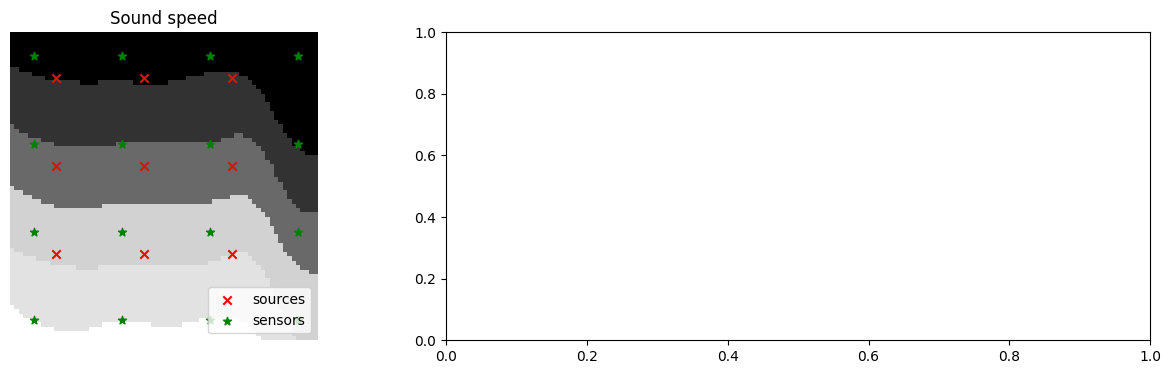

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})

ax[0].imshow(true_model, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker="*", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

# ax[1].plot(signal, label="Source 1", c="k")
# ax[1].set_title("Source signals")
#ax[1].get_yaxis().set_visible(False)

In [6]:
f0 = 200
dx = dy = 0.8
dt_ben = 12e-5
# n_steps_forward = int(326 * 3.63)
n_steps_forward = int(326 * 0.8)

density = jnp.ones_like(true_model) * 1000.0
pml_width = 2

# transform the sensors positions to the the same format as the receiver_is
receiver_is_modif = jnp.stack([sensors_positions[0], sensors_positions[1]], axis=-1)
source_modif = jnp.stack([source_positions[0], source_positions[1]], axis=-1)
num_sources = source_modif.shape[0]
# make the y coordinate 70 - y coordinate (seond value of the tuple)
# receiver_is_modif = jnp.stack([receiver_is_modif[:,0], 70 - receiver_is_modif[:,1]], axis=-1)
# source_modif = jnp.stack([source_modif[:,0], 70 - source_modif[:,1]], axis=-1)
# print(source_modif,receiver_is_modif)


# Use vmap to simulate wave propagation for all sources
# simulate_for_source = lambda source_i: acoustic2D(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif)
# simulate_for_source = lambda source_i: acoustic2D_pml_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=pml_width)
# simulate_for_source = lambda source_i: acoustic2D_pml_4th_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=10)
# p_data_true, wavefields = vmap(simulate_for_source)(source_modif)
p_test, wavefields_test = acoustic2D_pml_minmem(true_model, density, source_modif[0], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)

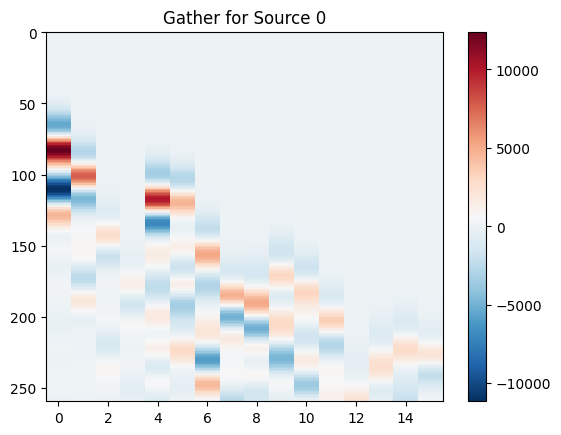

(260, 16)


In [7]:
# plot the gather for the first source
# minimum = np.amin(p_data_true[12])
plt.imshow((p_test), cmap="RdBu_r", interpolation="nearest", aspect="auto")
plt.colorbar()
plt.title('Gather for Source 0')
plt.show()
print(p_test.shape)

In [8]:
fcn_params = {
    "criterion_threshold": 1e-10,
    "regularisation_loss": 0.0,
    "norm_loss": 0.0,
    "top_k_loss": 0.0,
    "differentiable_mask_sharpness": 10.0,
    "number_of_k":10,
    "hidden_size": 56,
    "num_hidden_layers": 3,
    "learning_rate": 2e-2,
    "num_iterations": 15,
    "print_gradients": False,
    "num_sources": num_sources,
}

In [9]:
# Differentiable Mask
def differentiable_mask(probabilities, sharpness=10.0):
    return jax.nn.sigmoid(sharpness * (probabilities - 0.5))

# def top_k_regularization(soft_mask, k=10):
#     top_k_values = jax.lax.top_k(soft_mask, k)[0]
#     penalty = jnp.sum(soft_mask) - jnp.sum(top_k_values)
#     return penalty

def smooth_fun(gradient):
    # x = gradient.on_grid[..., 0]
    x = gradient
    for _ in range(1):
        x = smooth(x)
    return x
@jit
def fwi(src_position):
    print("source position in fwi", src_position)
    num_steps_fwi = 150
    key = random.PRNGKey(42)
    _, key = random.split(key)
    # initial model is the blurred model
    # params_fwi = blurred_model

    def simulate_true(src):
        p_rec, _ = acoustic2D_pml_minmem(
            true_model, density, src,
            f0, dx, dy, dt_ben, n_steps_forward,
            receiver_is_modif, pml_width=pml_width
        )
        return p_rec

    p_data_obs = vmap(simulate_true)(src_position)  # [Nsrc, Nt, Nrec]

    init_fun_fwi, update_fun_fwi, get_params_fwi = optimizers.adam(25.0, 0.9, 0.9)
    opt_state_fwi = init_fun_fwi(blurred_model)

    # print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

    def loss_func_fwi(opt_state_fwi, src_num):
        @jit
        def simulate_one(src_num):
            p_rec, _ = acoustic2D_pml_minmem(
                opt_state_fwi, density, src_position[src_num],
                f0, dx, dy, dt_ben, n_steps_forward,
                receiver_is_modif, pml_width=pml_width
            )
            return p_rec
        
        # simulate_all = jit(vmap(simulate_one))
        # p_pred = simulate_all(src_position)
        # p_pred,_ = acoustic2D_pml_minmem(params_fwi, density, src_position[src_num], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)
        p_pred = simulate_one(src_num)

        data = p_data_obs[src_num]

        print(p_pred.shape, data.shape)
        return jnp.mean((p_pred - data) ** 2)

    loss_with_grad_fwi = value_and_grad(loss_func_fwi,argnums=0)

    # Define and compile the update function
    @jit
    def update_fwi(opt_state, key, k):
        v = get_params_fwi(opt_state)
        src_num = random.choice(key, num_sources)
        lossval, gradient = loss_with_grad_fwi(v, src_num)
        gradient = smooth_fun(gradient)
        # gradient *= probabilities[src_num]
        return lossval, update_fun_fwi(k, gradient, opt_state)

    @jit
    def body(carry, k):
        opt_state, key = carry
        _, key = random.split(key)      # throw away first, keep second
        lossval, opt_state = update_fwi(opt_state, key, k)
        return (opt_state, key), lossval

    (opt_state_fwi, _), losses = lax.scan(body, (opt_state_fwi, key), jnp.arange(num_steps_fwi))
    new_params = get_params_fwi(opt_state_fwi)

    return new_params


nx, ny = true_model.shape

# we’ll clamp i ∈ [pml, nx-1-pml], j ∈ [pml, ny-1-pml]
@jit
def clamp_sources(src):
    i_clamped = jnp.clip(src[:,0], pml_width, nx - 1 - pml_width)
    j_clamped = jnp.clip(src[:,1], pml_width, ny - 1 - pml_width)
    return jnp.stack([i_clamped, j_clamped], axis=-1)

In [10]:
simulate_for_source = lambda source_i: acoustic2D_pml_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)
#     # simulate_for_source = lambda source_i: acoustic2D_pml_4th_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=10)
p_data_true, wavefields = vmap(simulate_for_source)(source_modif)
print(p_data_true.shape)

(9, 260, 16)


source position in fwi Traced<ShapedArray(float32[9,2])>with<DynamicJaxprTrace(level=1/0)>
(260, 16) (260, 16)


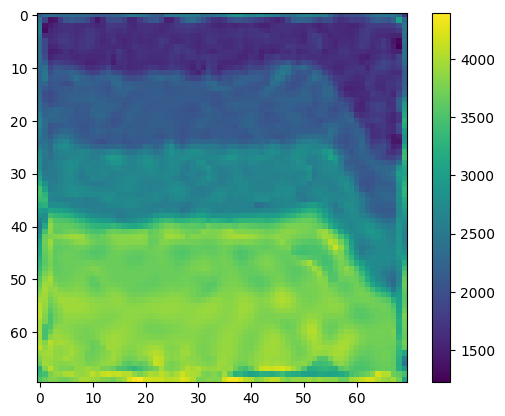

46930.93


In [11]:
iin = fwi(source_modif)
plt.imshow(iin)
plt.colorbar()
plt.show()
# L1 loss
print(jnp.linalg.norm((iin - jnp.fliplr(true_model)), ord=1))

In [12]:
# Differentiable Loss Function for the optimizer
def outer_loss(args):
    # probabilities = model(x)  # Predict probabilities
    # soft_mask = differentiable_mask(probabilities, sharpness)  # Generate soft mask
    
    

    # multiplier = matrix.shape[0] // soft_mask.shape[0]
    # soft_mask = jnp.repeat(soft_mask, multiplier, axis=0)

    # weighted_matrix = soft_mask[:, None] * matrix  # Apply mask to matrix rows

    # regularization_loss = mask_penalty * jnp.mean(soft_mask * (1 - soft_mask))  # Encourage binary mask
    # norm_loss = jnp.linalg.norm(soft_mask, ord=1)
    # top_k_loss = top_k_regularization(soft_mask, k=fcn_params["number_of_k"])

    # singular_loss = eigenvalue_criterion(weighted_matrix, threshold=criterion_threshold)
    inverted_model = fwi(args)
    # def simulate_rec(src):
    #     p_rec, _ = acoustic2D_pml_minmem(
    #         inverted_model, density, src,
    #         f0, dx, dy, dt_ben, n_steps_forward,
    #         receiver_is_modif, pml_width=pml_width
    #     )
    #     return p_rec

    # p_pred = vmap(simulate_rec)(args)
    
    # fwi_loss = jnp.linalg.norm((inverted_model - true_model), ord=1)
    fwi_loss = jnp.mean((inverted_model - true_model) ** 2)
    # data_loss = jnp.mean((p_pred - p_data_true) ** 2)

    # fwi_loss = lossval

    # logs["models"].append(inverted_model)


    # return -(singular_loss) + params["regularisation_loss"]*regularization_loss + params["norm_loss"]*norm_loss + params["top_k_loss"]*top_k_loss
    return fwi_loss #+ fcn_params["regularisation_loss"]*regularization_loss + fcn_params["norm_loss"]*norm_loss 
    # return data_loss

# loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)



In [13]:
# @partial(jit, static_argnums=(1))
@jit
def outer_step(fargs, state):

    # Print gradients for debugging
    def print_grads(grads):
        print("Gradients in step function:")

        def print_leaf(x):
            if x is None:
                print("None")
            else:
                print(x)
        jax.tree_util.tree_map(print_leaf, grads)


    loss, grad_src = jax.value_and_grad(outer_loss)(fargs)
    updates, state = outer_optimiser.update(grad_src, state)
    fargs = optax.apply_updates(fargs, updates)

    fargs = clamp_sources(fargs)
    
    return fargs, state, loss

In [14]:
fargs = source_modif
outer_optimiser = optax.adam(learning_rate=2.5)
opt_state = outer_optimiser.init(eqx.filter(fargs, eqx.is_array))
n_steps_outer = 20


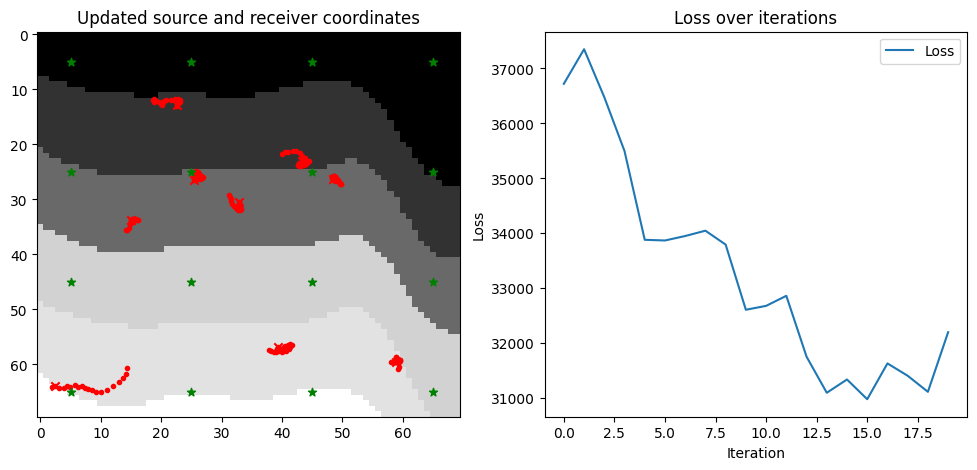

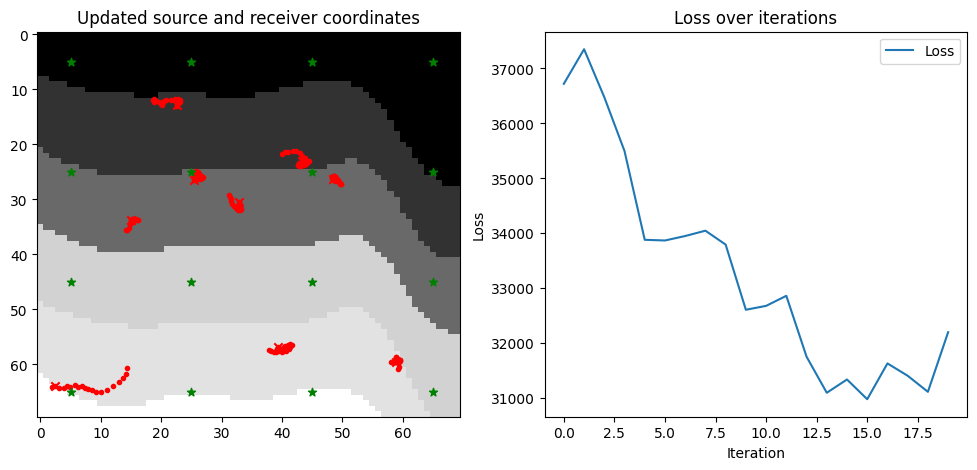

Final Loss: 32201.613


In [20]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time  # Optional, to simulate time between iterations

# Create the figure and two subplots outside the loop
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

lossvals = []
source_trajectories = []
receiver_trajectories = []

# simulate_for_source_i = lambda source_i: acoustic2D_pml_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)


for i in range(n_steps_outer):
    tic = time.time()

    # p_data_true, wavefields = vmap(simulate_for_source_i)(fargs)
    # print("p_data_true",p_data_true.shape)

    fargs, opt_state, lossval = outer_step(fargs, opt_state)
    lossvals.append(lossval)
    tac = time.time()
    print(f"Step {i}, Loss: {lossval}, Time: {tac - tic}")


    source_trajectories.append(fargs)  # Source
    receiver_trajectories.append(receiver_is_modif)  # Receiver



    # receiver_trajectories.append(receiver_coords[0],receiver_coords[1])  # Receiver

    # Clear the current axes, keeping the figure intact
    ax1.cla()
    ax2.cla()

    # if i % 1 == 0:
    # print(f"Step {i}, Loss: {lossval}")

    # Plot the sound speed on the first subplot
    im = ax1.imshow(true_model, cmap="gray", interpolation="nearest", aspect="auto")
    ax1.set_title("Updated source and receiver coordinates")

    # Plot the trajectories of the sources and receivers
    source_positions_traj = list(zip(*source_trajectories))
    receiver_positions_traj = list(zip(*receiver_trajectories))

    # print("source_trajectories",source_trajectories)
    # print("source_positions",source_positions_traj)
    
    # for positions in source_positions:
    #     ax1.plot(positions[0][1], positions[0][0], 'b-', label='Source Trajectory')

    for traj in source_trajectories:
        # for src in traj:
            # ax1.plot(src[1], src[0], 'b-', label='Source Trajectory')
            # print(src[1], src[0])
        ax1.scatter(*traj.T[::-1], color='r', marker='.')

    # ax1.plot(source_positions[1], source_positions[0], 'b-', label='Source Trajectory')
    ax1.plot(receiver_positions_traj[1], receiver_positions_traj[0], 'g-', label='Receiver Trajectory')

    # Plot the current positions of the source and receiver
    # ax1.scatter(fargs[0][0][1], fargs[0][0][0], marker='*', color='blue', label='Current Source Position')
    # plot all the src positions in fargs
    # print(fargs[0][0])
    
    # print("000",fargs[0][0][0])
    
    for src in fargs:
        ax1.scatter(*src.T[::-1], color='r', marker='x')


    # ax1.scatter(fargs[1][1][1], fargs[1][1][0], marker='x', color='red', label='Current Receiver Position')
    for rec in receiver_is_modif:
        ax1.scatter(*rec.T[::-1], color='g', marker='*')
    # ax1.scatter(receiver_coords[1], receiver_coords[0], marker='o', color='blue', label='Current Receiver Position')

    # print(fargs)

    # ax1.legend()

    # Plot the loss values over time on the second subplot
    ax2.plot(lossvals, label='Loss')
    ax2.set_title("Loss over iterations")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Loss")
    ax2.legend()

    # Update the plot display
    clear_output(wait=True)
    display(fig)
    # plt.savefig(f"opti_movie/step_{i}.png")

    # Force a draw before saving and displaying the figure
    fig.canvas.draw()

    # Save the figure after drawing everything
    # plt.savefig(f"opti_movie/step_{i}.png")

    # Clear the output, display the updated figure
    # clear_output(wait=True)
    # display(fig)

    # Pause to allow plot to refresh
    time.sleep(0.1)


    # plt.pause(0.01)  # Slight pause to allow plot to update
    # time.sleep(0.1)  # Optional, simulates time between iterations

# Show the final plot
plt.show()

print("Final Loss:", lossvals[-1])

# save the source_trajectories, receiver_trajectories and lossvals

jnp.save('source_trajectories.npy', source_trajectories)
jnp.save('receiver_trajectories.npy', receiver_trajectories)
jnp.save('lossvals.npy', lossvals)


In [23]:
final_model = fwi(fargs)
initial_model = fwi(source_modif)

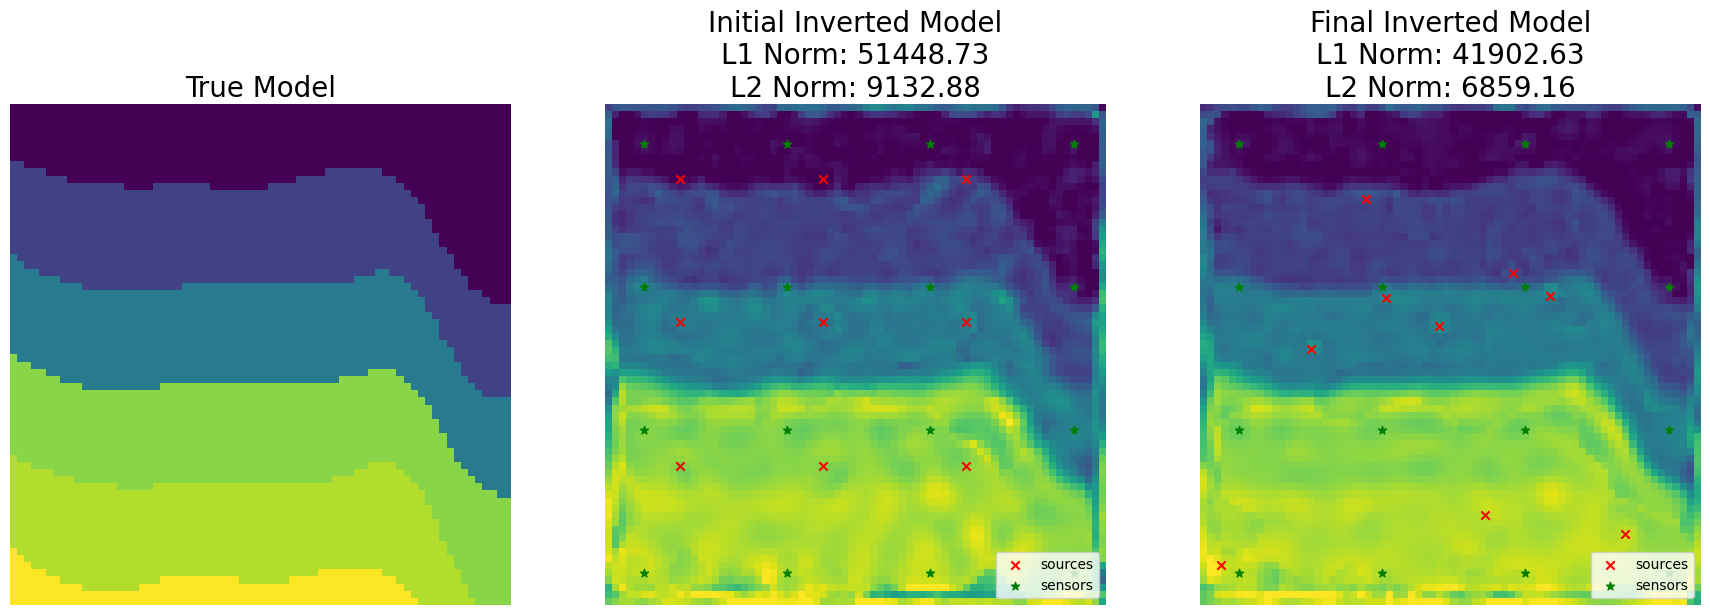

In [24]:
vmin, vmax = true_model.min(), true_model.max()

l1_norm_initial = jnp.linalg.norm((initial_model - true_model), ord=1)
l1_norm_final = jnp.linalg.norm((final_model - true_model), ord=1)

l2_norm_initial = jnp.linalg.norm((initial_model - true_model), ord=2)
l2_norm_final = jnp.linalg.norm((final_model - true_model), ord=2)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the true model
im = axes[0].imshow(true_model, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title('True Model', fontsize=20)
axes[0].axis('off')
# fig.colorbar(im, ax=axes[0], orientation='vertical')

# Plot the initial inverted model
im = axes[1].imshow(initial_model, cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].scatter(source_positions[1], source_positions[0], c="r", marker="x", label="sources")
axes[1].scatter(sensors_positions[1], sensors_positions[0], c="g", marker="*", label="sensors")
axes[1].set_title(f'Initial Inverted Model\nL1 Norm: {l1_norm_initial:.2f}\nL2 Norm: {l2_norm_initial:.2f}', fontsize=20)
axes[1].axis('off')
axes[1].legend(loc="lower right")
# fig.colorbar(im, ax=axes[1], orientation='vertical')

# Plot the final inverted model
im = axes[2].imshow(final_model, cmap='viridis', vmin=vmin, vmax=vmax)
axes[2].scatter(fargs[:,1], fargs[:,0], c="r", marker="x", label="sources")
axes[2].scatter(sensors_positions[1], sensors_positions[0], c="g", marker="*", label="sensors")
axes[2].set_title(f'Final Inverted Model\nL1 Norm: {l1_norm_final:.2f}\nL2 Norm: {l2_norm_final:.2f}', fontsize=20)
axes[2].axis('off')
axes[2].legend(loc="lower right")
# fig.colorbar(im, ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()


(260, 16)


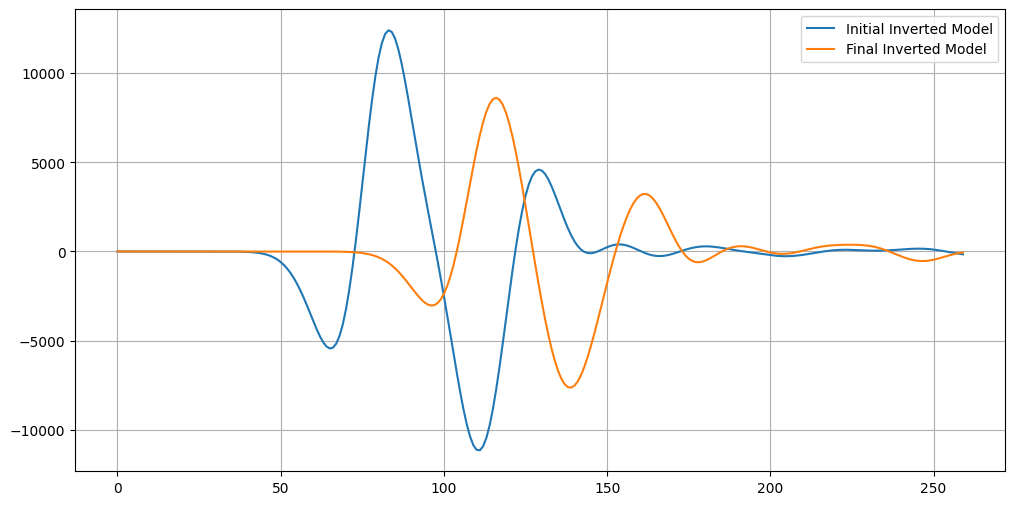

In [18]:
# Look at the initial, final  layout traces and true model traces
source_idx = 0
trace_index = 0

p_ini, wavefields_ini = acoustic2D_pml_minmem(true_model, density, source_modif[source_idx], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)

p_final, wavefields_final = acoustic2D_pml_minmem(final_model, density, fargs[source_idx], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)

print(p_ini.shape)

# plot a few traces
plt.figure(figsize=(12, 6))
plt.plot(p_ini[ :, trace_index], label='Initial Inverted Model')
plt.plot(p_final[ :, trace_index], label='Final Inverted Model')
plt.grid()
plt.legend()
plt.show()


In [19]:
print(fargs)

[[12.7791605 19.303455 ]
 [35.69497   14.041606 ]
 [59.72012   14.415601 ]
 [25.718302  26.575808 ]
 [28.667564  30.968739 ]
 [57.05716   37.029583 ]
 [25.177858  48.26858  ]
 [22.078947  39.991634 ]
 [60.830048  58.83916  ]]
